In [563]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Data loading

## Movie data

In [564]:
# Load films
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
#movies['runtime'].hist()


(81741, 9)


In [671]:
movies.head(5)

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,16
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None,None


In [672]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,61286.000000
mean,1.740784e+07,4.799363e+07,93.651871
std,1.098791e+07,1.121753e+08,51.513103
min,3.300000e+02,1.000000e+04,0.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,5100.000000


# TO DO

Observed issues: 

The date format is not constant, sometimes it's the year only, sometimes it's yyyy-mm-dd

Box office revenue is not always available: NaN + Should take into account inflation

For language, countries and genres there's a code in addition to the information (can we use it??)

To check : 

Missing values

Outliars: height way too big 

Are their any duplicated when considering number of movies?

Calculate a weighted rating : vote * rating?

### Find data set with budget spent!!!

## Character data

In [565]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
270164,11776754,/m/02rrxmy,1997-08-20,NaN,1940-07-18,M,1.93,NaN,James Brolin,57.0,/m/0cgh7zv,NaN,/m/01zg98
421858,33341963,/m/0h2d789,2012,Larry's date,NaN,F,NaN,NaN,Yulia Lukin,NaN,/m/0h8pt24,/m/0h8pt27,/m/0h8pt2g
314621,13265530,/m/03b_t54,1996,NaN,1959-08-28,M,1.85,NaN,John Allen Nelson,36.0,/m/0bysd3s,NaN,/m/0bk1bq
247085,5651515,/m/0dy97w,2005,NaN,1980-08-19,F,NaN,NaN,Aimee-Lynn Chadwick,24.0,/m/040sp12,NaN,/m/0kt405
21854,246355,/m/01kn80,1966-11-05,Master's Wife,NaN,F,NaN,NaN,Stephanie Nielson,NaN,/m/0hm_bkn,/m/0hm_brx,/m/0hm_bkr


freebase_character_actor_map_id ?
movies are referred to by wikipedia id or freebase id
lots of data missing especially for: ethnicity, charcter name (maybe some characters aren't named in movies) , 
different date formats for release date 

## IMDB data

In [566]:
imdb_top_1000 = pd.read_csv('data/imdb/imdb_top_1000.csv', thousands=',')

In [567]:
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


In [568]:
imdb_budget = pd.read_csv('data/imdb/IMDb_budgets.csv')

In [569]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
1332,Overboard,2018,6.0,PG-13,112,"Comedy, Romance","May 4, 2018",12000000,50316123,85369830
2588,The Raven,2012,6.4,R,110,"Crime, Mystery, Thriller","Apr 12, 2012",26000000,16008272,30601801
791,Jumper,2008,6.1,PG-13,88,"Action, Adventure, Sci-Fi","Feb 14, 2008",82500000,80172128,222640812
2474,The Howling,1981,6.6,R,91,Horror,"Apr 10, 1981",1000000,17985000,17985000
139,Mrs. Doubtfire,1993,7.0,PG-13,125,"Comedy, Drama, Family","Nov 24, 1993",25000000,219195051,441286003


# Cleaning & Pre-processing of data

In [570]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [571]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [572]:
# Function to remove encoding: 
remove_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [573]:
movies['genres'] = movies['genres'].apply(remove_encoding)
movies['languages'] = movies['languages'].apply(remove_encoding)
movies['countries'] = movies['countries'].apply(remove_encoding)
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [574]:
movies['countries'].apply(np.shape).min()

()

### Clean release dates

In [575]:
# Replace string 'release_date' column with 3 float columns ['release_year','release_month','release_day']

movies['release_date'] = movies['release_date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(movies['release_date'].str.split('-', expand=True).values, columns=['release_year','release_month','release_day']) # Split between days, months and year
movies[['release_year','release_month','release_day']] = release_date
movies = movies.drop('release_date', axis=1)


In [576]:
movies.head()

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,16
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None,None


### Remove data that is out of this world 

In [577]:
def replace_outliers_with_nan(df, col, possible_range):
    df[col] = df[col].apply(lambda x: np.nan if x < possible_range[0] or x > possible_range[1] else x)

#### Movies

In [578]:
possible_movie_runtime_range = [0, 85 * 60] # 85 hours is the Guinness World Record for the longest movie - The Cure for Insomnia

In [579]:
replace_outliers_with_nan(movies, 'runtime', possible_movie_runtime_range)

In [580]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,61286.000000
mean,1.740784e+07,4.799363e+07,93.651871
std,1.098791e+07,1.121753e+08,51.513103
min,3.300000e+02,1.000000e+04,0.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,5100.000000


In [581]:
movies[movies['runtime'] == 0]

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,NaN,0.0,[English],[United States of America],[Short Film],1894,None,None


The real length of Dickson Experimental Sound Film is 17 seconds which rounded to minutes is 0.

#### Characters

Remove age and height that are incorrect or corrupted

In [582]:
possible_age_range = (0, 150)
possible_height_range = (0, 3)

In [583]:
replace_outliers_with_nan(characters, 'actor_age_at_movie_release', possible_age_range)
replace_outliers_with_nan(characters, 'actor_height_meters', possible_height_range)

Add ethnicity labels using the freebase ethnicity ids

In [584]:
ethnicity_freebase_ids = pd.read_csv('handled_data/ethnicities_freebase_ids.csv', index_col=0)

In [585]:
def get_actor_ethnicity_label(row):
    try:
        ethnicity_label = ethnicity_freebase_ids.loc[row['actor_ethnicity_freebase_id'], 'ethnicity_label']
    except:
        ethnicity_label = np.NaN
    return ethnicity_label


In [586]:
characters['actor_ethnicity'] = characters.apply(lambda row: get_actor_ethnicity_label(row),axis=1)

In [587]:
characters

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,actor_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,unknown
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,English people
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN


In [588]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154809.000000,292175.000000
mean,1.396975e+07,1.748177,37.890901
std,1.079662e+07,0.106249,14.085909
min,3.300000e+02,0.610000,0.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,2.356000,103.000000


### IMDB

In [589]:
imdb_top_1000['Runtime'].str.contains(r'\d+ min').value_counts()

True    1000
Name: Runtime, dtype: int64

In [590]:
imdb_top_1000['Runtime'] = imdb_top_1000['Runtime'].str.extract(r'(\d+) min', expand=False).astype(int)
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


In [591]:
imdb_top_1000.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,1000.000000,1000.000000,843.000000,1.000000e+03,8.310000e+02
mean,122.891000,7.949300,77.971530,2.736929e+05,6.803475e+07
std,28.093671,0.275491,12.376099,3.273727e+05,1.097500e+08
min,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,103.000000,7.700000,70.000000,5.552625e+04,3.253559e+06
50%,119.000000,7.900000,79.000000,1.385485e+05,2.353089e+07
75%,137.000000,8.100000,87.000000,3.741612e+05,8.075089e+07
max,321.000000,9.300000,100.000000,2.343110e+06,9.366622e+08


In [592]:
imdb_top_1000.dtypes

Poster_Link       object
Series_Title      object
Released_Year     object
Certificate       object
Runtime            int64
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross            float64
dtype: object

To estimate a movie success, we need to both account for the rating 'IMDB_Rating' and to the correponding number of votes 'No_of_Votes'. To do so, we build a new weighted rating based on a shrinkage estimator: 

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:

R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed (currently 25088)

C = the mean vote across the whole report (currently 7.94)

[Text(0.5, 1.0, 'Distribution of IMDB ratings'),
 Text(0.5, 0, 'IMDB rating'),
 Text(0, 0.5, 'Number of films')]

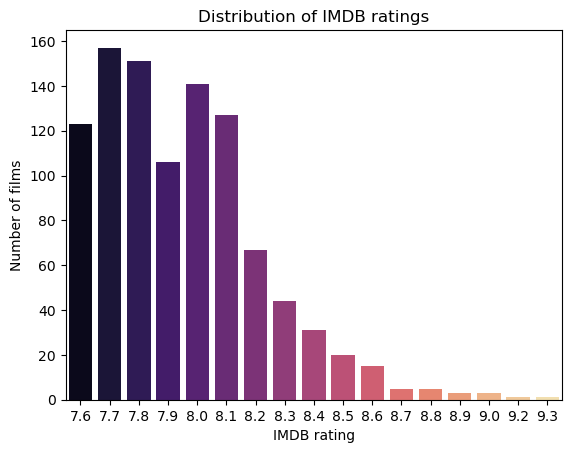

In [593]:
sns.countplot(x='IMDB_Rating', data = imdb_top_1000, palette="magma").set(title='Distribution of IMDB ratings',xlabel='IMDB rating', ylabel='Number of films')


[Text(0.5, 1.0, 'Distribution of IMDB ratings'),
 Text(0.5, 0, 'IMDB rating'),
 Text(0, 0.5, 'Number of films')]

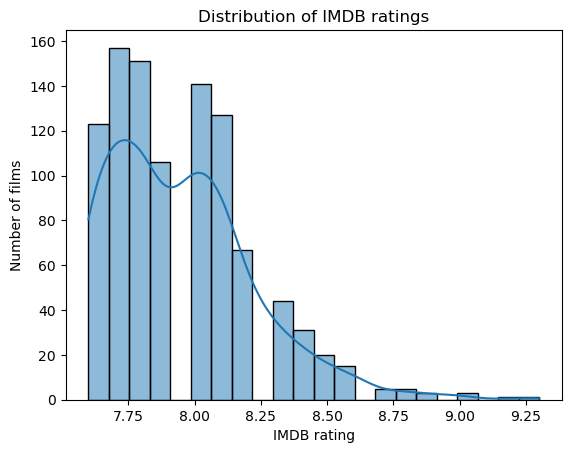

In [594]:
sns.histplot(x='IMDB_Rating', data = imdb_top_1000, kde=True).set(title='Distribution of IMDB ratings',xlabel='IMDB rating', ylabel='Number of films')


In [595]:
C = imdb_top_1000['IMDB_Rating'].mean()
m = 25000#imdb_top_1000['No_of_Votes'].min()
v = imdb_top_1000['No_of_Votes']
R = imdb_top_1000['IMDB_Rating']

In [596]:
imdb_top_1000['WR'] = (v / (v + m)) * R + (m / (v + m)) * C


To check if the weighted rating has worked, we display below the best rated movie. We observe that for an IMDB rating of 9/10, the weighted rating WR is better for movies with the most votes. We conclude that this weighted rating is more representative of a movie' success.

In [597]:
imdb_top_1000[['Series_Title','IMDB_Rating','WR','No_of_Votes']].sort_values('WR', ascending=False).head()

,Series_Title,IMDB_Rating,WR,No_of_Votes
0,The Shawshank Redemption,9.3,9.285741,2343110
1,The Godfather,9.2,9.180997,1620367
2,The Dark Knight,9.0,8.988718,2303232
3,The Godfather: Part II,9.0,8.977257,1129952
4,12 Angry Men,9.0,8.963254,689845


TEST : ISSUE HERE

In [598]:
imdb_top_1000[['Series_Title','IMDB_Rating','WR','No_of_Votes']].sort_values('WR', ascending=True).head()

,Series_Title,IMDB_Rating,WR,No_of_Votes
928,300,7.6,7.611522,732876
947,Harry Potter and the Sorcerer's Stone,7.6,7.612782,658185
914,Sherlock Holmes,7.6,7.614359,583158
887,Guardians of the Galaxy Vol. 2,7.6,7.614677,569974
879,Once Upon a Time... in Hollywood,7.6,7.615152,551309


[Text(0.5, 1.0, 'Distribution of weighted ratings on IMDB database'),
 Text(0.5, 0, 'Weighted rating WR'),
 Text(0, 0.5, 'Number of films')]

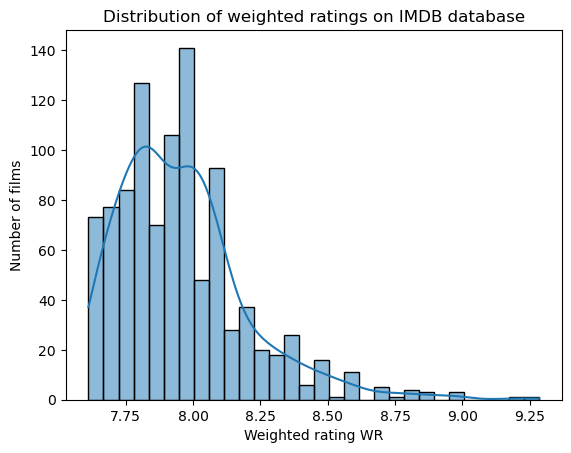

In [599]:
sns.histplot(x='WR', data = imdb_top_1000, kde=True).set(title='Distribution of weighted ratings on IMDB database',xlabel='Weighted rating WR', ylabel='Number of films')


### Merge IMDB database with movie database to have common features

In [600]:
movie_feature = imdb_top_1000.merge(movies, left_on='Series_Title', right_on='name',how='inner')

In [601]:
print(f'There are {movie_feature.shape[0]} common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes {imdb_top_1000.shape[0]} elements and Movie corpus includes {movies.shape[0]}.')


There are 875 common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes 1000 elements and Movie corpus includes 81741.


In [602]:
movie_feature.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'WR',
       'wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

[Text(0.5, 1.0, 'Distribution of weighted ratings on merged database'),
 Text(0.5, 0, 'Weighted rating WR'),
 Text(0, 0.5, 'Number of films')]

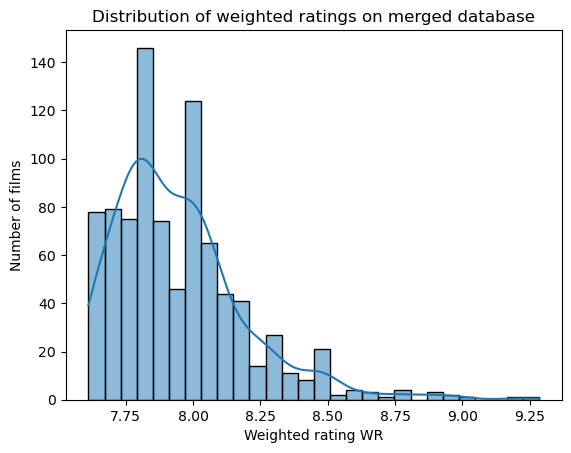

In [603]:
sns.histplot(x='WR', data = movie_feature, kde=True).set(title='Distribution of weighted ratings on merged database',xlabel='Weighted rating WR', ylabel='Number of films')


### Fill missing budget data from imdb budget dataset

In [604]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
480,Salt,2010,6.4,PG-13,100,"Action, Mystery, Thriller","Jul 23, 2010",130000000,118311368,290650494
2860,In the Land of Women,2007,6.4,PG-13,97,"Comedy, Drama, Romance","Apr 20, 2007",10500000,11052958,14140402
1929,From Hell,2001,6.8,R,122,"Horror, Mystery, Thriller","Oct 19, 2001",35000000,31598308,68712365
3475,Iris,2001,7.0,R,91,"Biography, Drama, Romance","Dec 14, 2001",5500000,5580479,5692941
2696,The Emperor's Club,2002,6.9,PG-13,109,Drama,"Nov 22, 2002",12500000,14060950,16193713


In [605]:
imdb_budget.describe()

,Year,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross
count,3828.000000,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03
mean,2003.594044,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08
std,12.767740,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08
min,1925.000000,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00
25%,1999.000000,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07
50%,2006.000000,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07
75%,2013.000000,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08
max,2020.000000,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09


In [606]:
imdb_budget['Release Date'] = imdb_budget['Release Date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(pd.to_datetime(imdb_budget['Release Date']).apply(lambda x: [x.year, x.month, x.day]).tolist(), columns=['release_year','release_month','release_day'])
imdb_budget[['release_year','release_month','release_day']] = release_date


In [607]:
#list(movie_feature['release_year'].unique())

In [608]:
#movie_feature['release_year'] = movie_feature['release_year'].replace('nan', np.nan).astype('Int16')
#movie_feature['release_month'] = movie_feature['release_month'].replace('nan', np.nan).astype('Int16')
#movie_feature['release_day'] = movie_feature['release_day'].replace('nan', np.nan).astype('Int16')

In [609]:
imdb_budget['release_year'] = imdb_budget['release_year'].astype('Int16')
imdb_budget['release_month'] = imdb_budget['release_month'].astype('Int16')
imdb_budget['release_day'] = imdb_budget['release_day'].astype('Int16')

In [610]:
imdb_budget.drop(['Year', 'IMDb', 'Rating', 'Runtime', 'Release Date'], axis=1, inplace=True)
imdb_budget.rename({'Movie': 'name', 'Genre': 'genres'}, axis=1, inplace=True)
imdb_budget.columns

Index(['name', 'genres', 'Production Budget', 'Domestic Gross',
       'Worldwide Gross', 'release_year', 'release_month', 'release_day'],
      dtype='object')

In [611]:
imdb_budget.describe()

,Production Budget,Domestic Gross,Worldwide Gross,release_year,release_month,release_day
count,3.828000e+03,3.828000e+03,3.828000e+03,3828.000000,3828.000000,3828.000000
mean,4.030960e+07,5.559021e+07,1.206910e+08,2003.594044,7.322100,15.891066
std,4.480927e+07,7.403263e+07,1.993646e+08,12.767740,3.378479,8.437532
min,7.000000e+03,0.000000e+00,0.000000e+00,1925.000000,1.000000,1.000000
25%,1.100000e+07,1.180967e+07,1.690363e+07,1999.000000,5.000000,9.000000
50%,2.500000e+07,3.225471e+07,5.077617e+07,2006.000000,8.000000,16.000000
75%,5.000000e+07,6.848642e+07,1.388776e+08,2013.000000,10.000000,23.000000
max,4.000000e+08,8.583730e+08,2.797801e+09,2020.000000,12.000000,31.000000


In [612]:
movie_feature.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,WR,wikipedia_id,box_office_revenue,runtime
count,875.000000,875.000000,763.000000,8.750000e+02,7.400000e+02,875.000000,8.750000e+02,5.240000e+02,818.000000
mean,124.666286,7.934171,78.474443,2.946588e+05,7.572251e+07,7.946176,7.492496e+06,1.398682e+08,118.013203
std,32.490318,0.275648,12.559687,3.380820e+05,1.095308e+08,0.245953,1.026922e+07,2.506817e+08,35.676872
min,64.000000,7.600000,28.000000,2.593800e+04,3.296000e+03,7.611522,3.746000e+03,1.047400e+04,2.000000
25%,102.000000,7.700000,71.000000,6.353300e+04,6.190768e+06,7.771961,1.715650e+05,1.199760e+07,96.000000
50%,120.000000,7.900000,79.000000,1.598860e+05,3.530697e+07,7.908253,1.673949e+06,5.111259e+07,114.000000
75%,138.000000,8.100000,88.000000,4.059220e+05,1.004922e+08,8.064510,1.245293e+07,1.358420e+08,133.000000
max,321.000000,9.300000,100.000000,2.343110e+06,7.605076e+08,9.285741,3.692924e+07,2.782275e+09,360.000000


In [613]:
imdb_budget['genres'] = imdb_budget['genres'].apply(lambda x: x.split(', '))

In [614]:
movie_feature.update(imdb_budget)

In [615]:
movie_feature['release_year'] = movie_feature['release_year'].astype('Int16')
movie_feature['release_month'] = movie_feature['release_month'].astype('Int16')
movie_feature['release_day'] = movie_feature['release_day'].astype('Int16')

In [616]:
movie_feature.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,WR,wikipedia_id,box_office_revenue,runtime,release_year,release_month,release_day
count,875.000000,875.000000,763.000000,8.750000e+02,7.400000e+02,875.000000,8.750000e+02,5.240000e+02,818.000000,875.000000,875.000000,875.000000
mean,124.666286,7.934171,78.474443,2.946588e+05,7.572251e+07,7.946176,7.492496e+06,1.398682e+08,118.013203,2004.691429,7.432000,15.966857
std,32.490318,0.275648,12.559687,3.380820e+05,1.095308e+08,0.245953,1.026922e+07,2.506817e+08,35.676872,11.834803,3.243142,8.340030
min,64.000000,7.600000,28.000000,2.593800e+04,3.296000e+03,7.611522,3.746000e+03,1.047400e+04,2.000000,1937.000000,1.000000,1.000000
25%,102.000000,7.700000,71.000000,6.353300e+04,6.190768e+06,7.771961,1.715650e+05,1.199760e+07,96.000000,2000.000000,5.000000,9.000000
50%,120.000000,7.900000,79.000000,1.598860e+05,3.530697e+07,7.908253,1.673949e+06,5.111259e+07,114.000000,2007.000000,7.000000,16.000000
75%,138.000000,8.100000,88.000000,4.059220e+05,1.004922e+08,8.064510,1.245293e+07,1.358420e+08,133.000000,2013.000000,11.000000,23.000000
max,321.000000,9.300000,100.000000,2.343110e+06,7.605076e+08,9.285741,3.692924e+07,2.782275e+09,360.000000,2020.000000,12.000000,31.000000


In [617]:
imdb_budget.drop(['release_year', 'release_month', 'release_day', 'genres'], axis=1, inplace=True)

In [618]:
movie_feature_with_budget = pd.merge(movie_feature, imdb_budget, on='name',  how='left')

In [619]:
movie_feature_with_budget.sample(5)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,...,runtime,languages,countries,genres,release_year,release_month,release_day,Production Budget,Domestic Gross,Worldwide Gross
898,https://m.media-amazon.com/images/M/MV5BMzZiOD...,Watership Down,1978,U,91,"Animation, Adventure, Drama",7.6,Hoping to escape destruction by human develope...,64.0,Martin Rosen,...,93.0,[English],[United Kingdom],"[Drama, Romance, Western]",1998,5,15,60000000,75383563,186883563
256,https://m.media-amazon.com/images/M/MV5BY2I0MW...,On the Waterfront,1954,A,108,"Crime, Drama, Thriller",8.1,An ex-prize fighter turned longshoreman strugg...,91.0,Elia Kazan,...,108.0,[English],[United States of America],"[Horror, Mystery, Thriller]",2019,3,20,20000000,175084580,256169079
501,https://m.media-amazon.com/images/M/MV5BMTAxYj...,Nosferatu,1922,NaN,94,"Fantasy, Horror",7.9,Vampire Count Orlok expresses interest in a ne...,NaN,F.W. Murnau,...,84.0,"[Silent film, German]",[Germany],"[Action, Comedy, Crime]",2010,8,6,100000000,119219978,170936470
698,https://m.media-amazon.com/images/M/MV5BM2FlNz...,Happiness,1998,NaN,134,"Comedy, Drama",7.7,The lives of several individuals intertwine as...,81.0,Todd Solondz,...,76.0,"[Silent film, English]",[United States of America],"[Action, Adventure, Western]",2016,9,12,90000000,93432655,162525156
191,https://m.media-amazon.com/images/M/MV5BMTkxNz...,Million Dollar Baby,2004,UA,132,"Drama, Sport",8.1,A determined woman works with a hardened boxin...,86.0,Clint Eastwood,...,100.0,[English],[United States of America],"[Action, Adventure, Thriller]",2015,10,6,300000000,200074175,879500760


In [642]:
movie_feature_with_budget['profit'] = movie_feature_with_budget['Worldwide Gross'] - movie_feature_with_budget['Production Budget']

In [643]:
movie_feature_with_budget.describe()

# original : box office revenue : 552 movies 
# IMDB  : gross revenue : 774 movies 
# IMDB dataset with budget spent : budget, domestic gross, worldwide gross : 915 movies 



,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,WR,wikipedia_id,box_office_revenue,runtime,release_year,release_month,release_day,Production Budget,Domestic Gross,Worldwide Gross,profit
count,915.000000,915.000000,802.000000,9.150000e+02,7.740000e+02,915.000000,9.150000e+02,5.520000e+02,855.000000,915.000000,915.000000,915.000000,9.150000e+02,9.150000e+02,9.150000e+02,9.150000e+02
mean,124.730055,7.939126,78.523691,3.021651e+05,7.623901e+07,7.950764,7.402548e+06,1.430743e+08,118.171696,2004.548634,7.408743,15.864481,8.191084e+07,1.549634e+08,3.609426e+08,2.790317e+08
std,32.449495,0.279299,12.428475,3.491507e+05,1.091009e+08,0.250094,1.023047e+07,2.509449e+08,35.388353,12.179663,3.239717,8.307756,6.271666e+07,9.880299e+07,3.007794e+08,2.637485e+08
min,64.000000,7.600000,28.000000,2.593800e+04,3.296000e+03,7.611522,3.746000e+03,1.047400e+04,2.000000,1937.000000,1.000000,1.000000,3.250000e+05,8.817450e+05,8.817450e+05,-2.411826e+07
25%,102.000000,7.700000,71.000000,6.356000e+04,6.290794e+06,7.773736,1.673350e+05,1.221116e+07,96.000000,1999.000000,5.000000,9.000000,3.200000e+07,9.257084e+07,1.761823e+08,1.220421e+08
50%,120.000000,7.900000,79.000000,1.644620e+05,3.564609e+07,7.909029,1.643298e+06,5.183651e+07,114.000000,2007.000000,7.000000,16.000000,6.800000e+07,1.250140e+08,2.668243e+08,1.941042e+08
75%,138.000000,8.100000,88.000000,4.171780e+05,1.009911e+08,8.074705,1.225605e+07,1.479548e+08,133.000000,2013.000000,11.000000,23.000000,1.200000e+08,1.799474e+08,4.328521e+08,3.416571e+08
max,321.000000,9.300000,100.000000,2.343110e+06,7.605076e+08,9.285741,3.692924e+07,2.782275e+09,360.000000,2020.000000,12.000000,31.000000,4.000000e+08,8.583730e+08,2.797801e+09,2.551701e+09


# Exploratory Data Analysis

Looking at the impacts of features on eachother by drawing a correlation heatmap

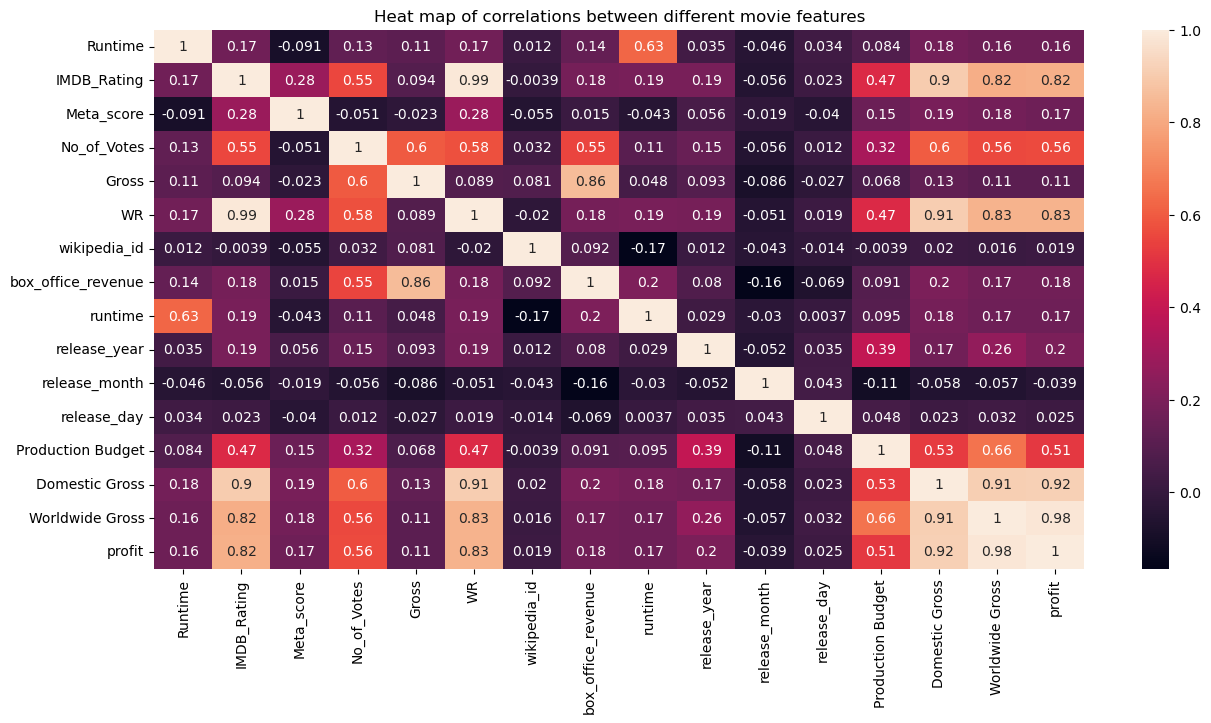

In [644]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(movie_feature_with_budget.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


Success indicators: 

- IMDB rating -> weighted rating : WR 
- gross revenue (15000 types) 
- wikipedia ID connection query : how much a movie lasts in time
- profit = revenue - budget 

1. correlation btw success indicators 
2. Check if we have the same successful movies & actors according to different indicators
3. Succesfulness = function (all indicators) 



Actor success: 
Weight in terms of number of apparearance and movie WR

### Impact of release date on success

To assess the impact of release date on success, we need to use the information on 'release_month' for each movie and need to choose a feature for success which can be either the IMDB weighted rating 'WR' or the 'box_office_revenue'. Since 'WR' and 'release_month' are features coming from two different datasets, we need to use the merged dataframe movie_feature which contains only 875. We can then compare the results found with ('WR','release_month') to ('box_office_revenue','release_month') which is based on much more data: 81741. 

-> CAREFUL, WHY ARE RATINGS AND GROSS REVENUE COMPLETELY UNCORRELATED ? 

In [645]:
df_release = movie_feature.dropna(how='all', subset=['release_month']) # Remove NaN months

In [646]:
movies['release_month'].describe()

count     42667
unique       12
top          09
freq       4268
Name: release_month, dtype: object

In [647]:
df_release.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'WR',
       'wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [648]:
df_release=df_release.sort_values(by='release_month', ascending=True)

Text(0.5, 1.0, 'Successfulness of Movie Release By Month')

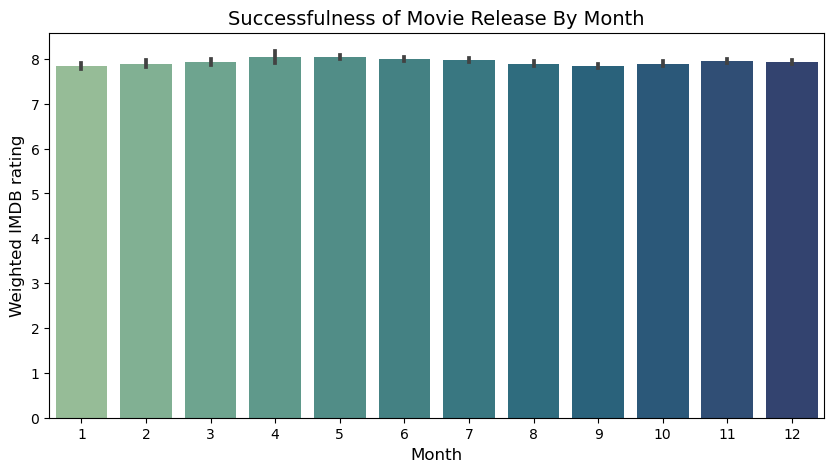

In [649]:
# Plot
plt.figure(figsize=(10,5))
ax7 = sns.barplot(x="release_month", y="WR",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted IMDB rating', fontsize=12)
plt.title('Successfulness of Movie Release By Month', fontsize=14)

Text(0.5, 1.0, 'Successfulness in terms of box office revenue of Movie Release By Month')

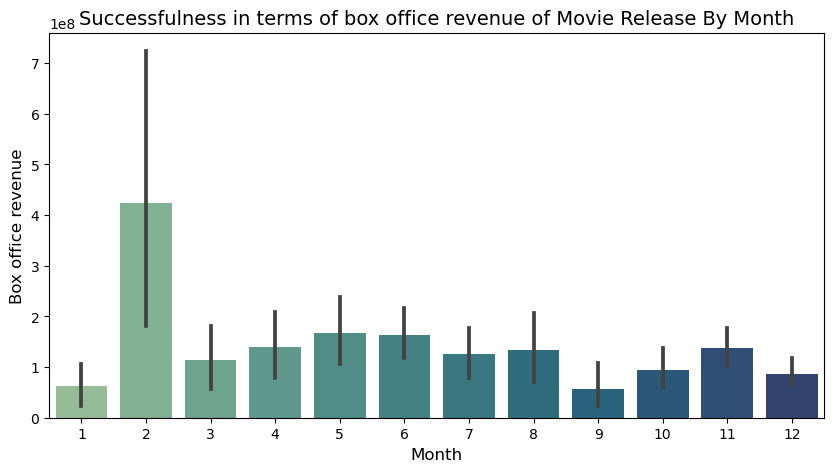

In [650]:
# Plot
plt.figure(figsize=(10,5))
ax7 = sns.barplot(x="release_month", y="box_office_revenue",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Box office revenue', fontsize=12)
plt.title('Successfulness in terms of box office revenue of Movie Release By Month', fontsize=14)

Text(0.5, 1.0, 'Successfulness in terms of gross revenue of Movie Release By Month')

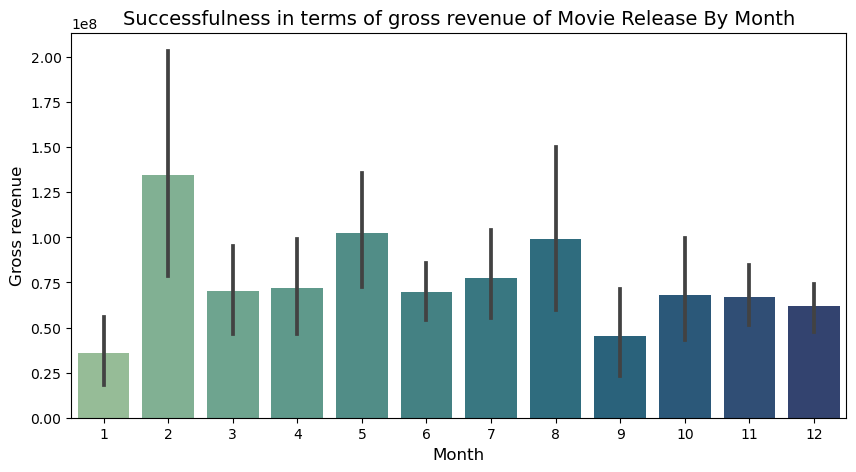

In [651]:
# Plot
plt.figure(figsize=(10,5))
ax7 = sns.barplot(x="release_month", y="Gross",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Gross revenue', fontsize=12)
plt.title('Successfulness in terms of gross revenue of Movie Release By Month', fontsize=14)

## What budget should be spent on a successful movie?

To see what budget should be spent on a successful movie, we want to compare maintly three features, the budget spent 'Production Budget', the profit made 'profit' and the rating of the movie to account for successfulness.

CHECK FOR SUCCESSFULNESS. 

As our movie database has movies dating back to 1921, we need to adjust the budgets and profits through an inflation rate

In [652]:
movie_feature_with_budget.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'WR',
       'wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'release_month',
       'release_day', 'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'profit', 'genre1'],
      dtype='object')

In [653]:
min(movie_feature_with_budget['Released_Year'])

'1921'

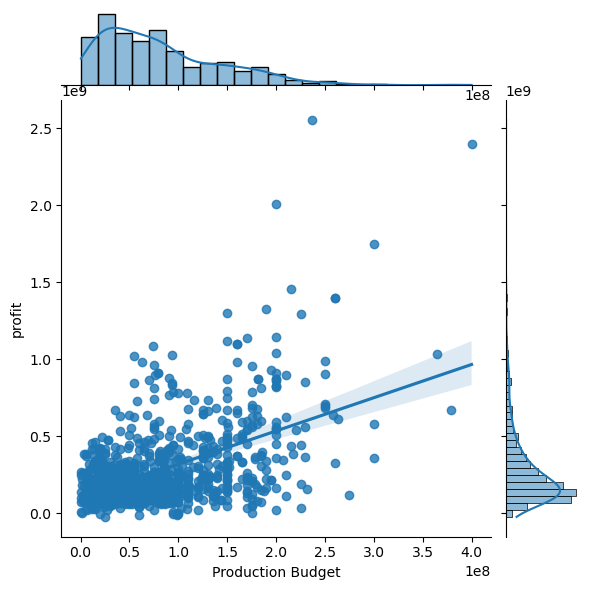

In [654]:
sns.jointplot(data=movie_feature_with_budget, x='Production Budget', y='profit', kind="reg");



To do : Split between high budget movies and average budget and check same graph 

The positive trend line indicates that an increase in the budget will result in an increase in profit.

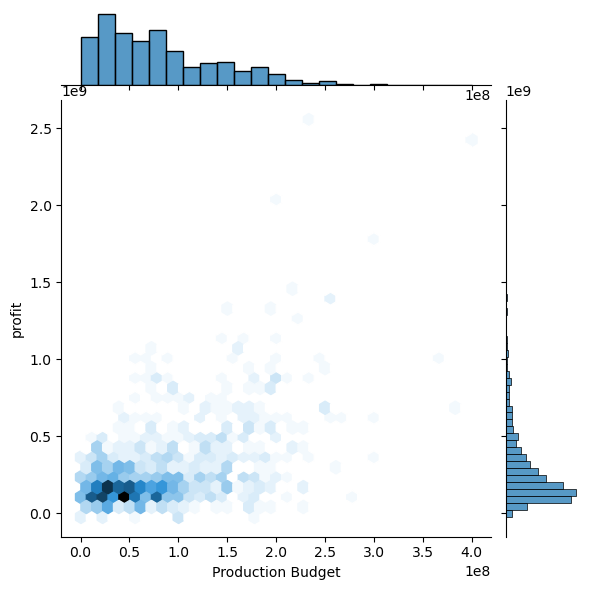

In [655]:
sns.jointplot(data=movie_feature_with_budget, x='Production Budget', y='profit', kind="hex");


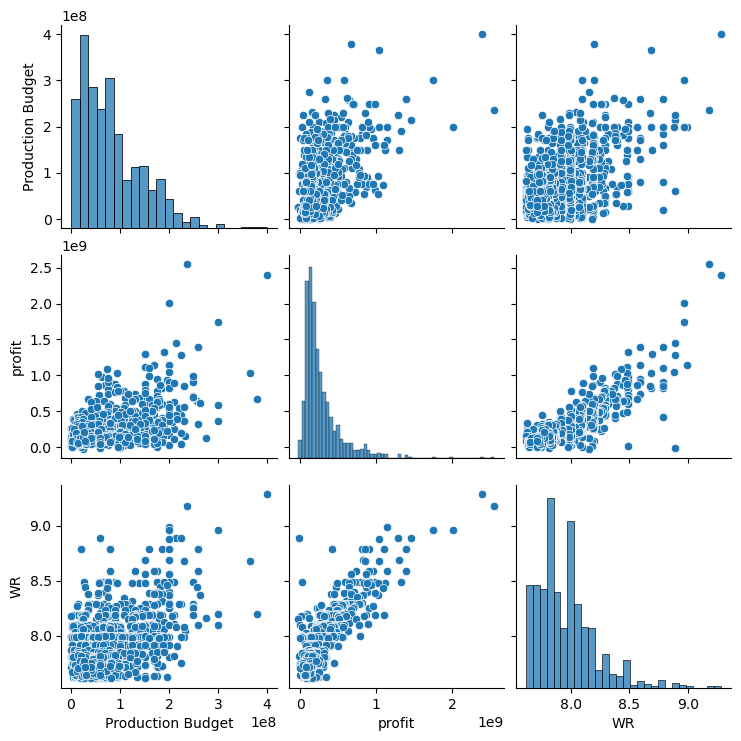

In [656]:
sns.pairplot(movie_feature_with_budget[['Production Budget','profit','WR']])

In [657]:
Top20_ProfitableMovies = movie_feature_with_budget.sort_values('profit', ascending=False).head(20)

Profit margin 

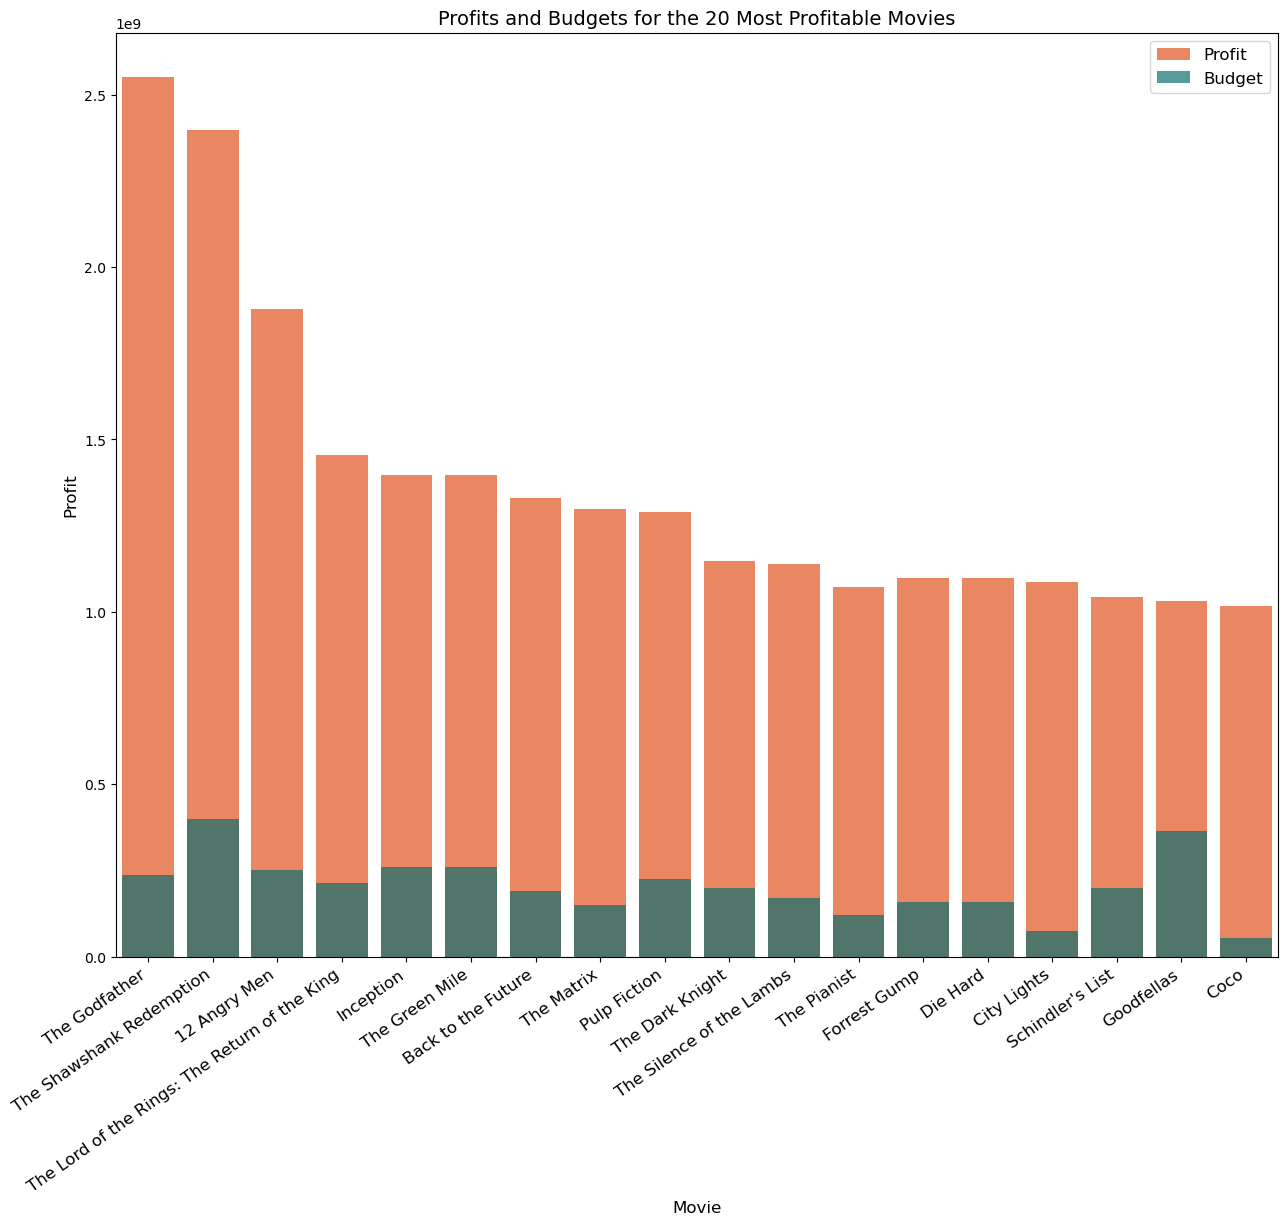

In [658]:
plt.figure(figsize=(15,12))
sns.barplot(x=Top20_ProfitableMovies['Series_Title'],y=Top20_ProfitableMovies['profit'], 
            color='orangered', alpha=0.7, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Series_Title'],y=Top20_ProfitableMovies['Production Budget'], 
            color='teal', alpha=0.7, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Profits and Budgets for the 20 Most Profitable Movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=12)
plt.legend(fontsize=12)

## Impact of director

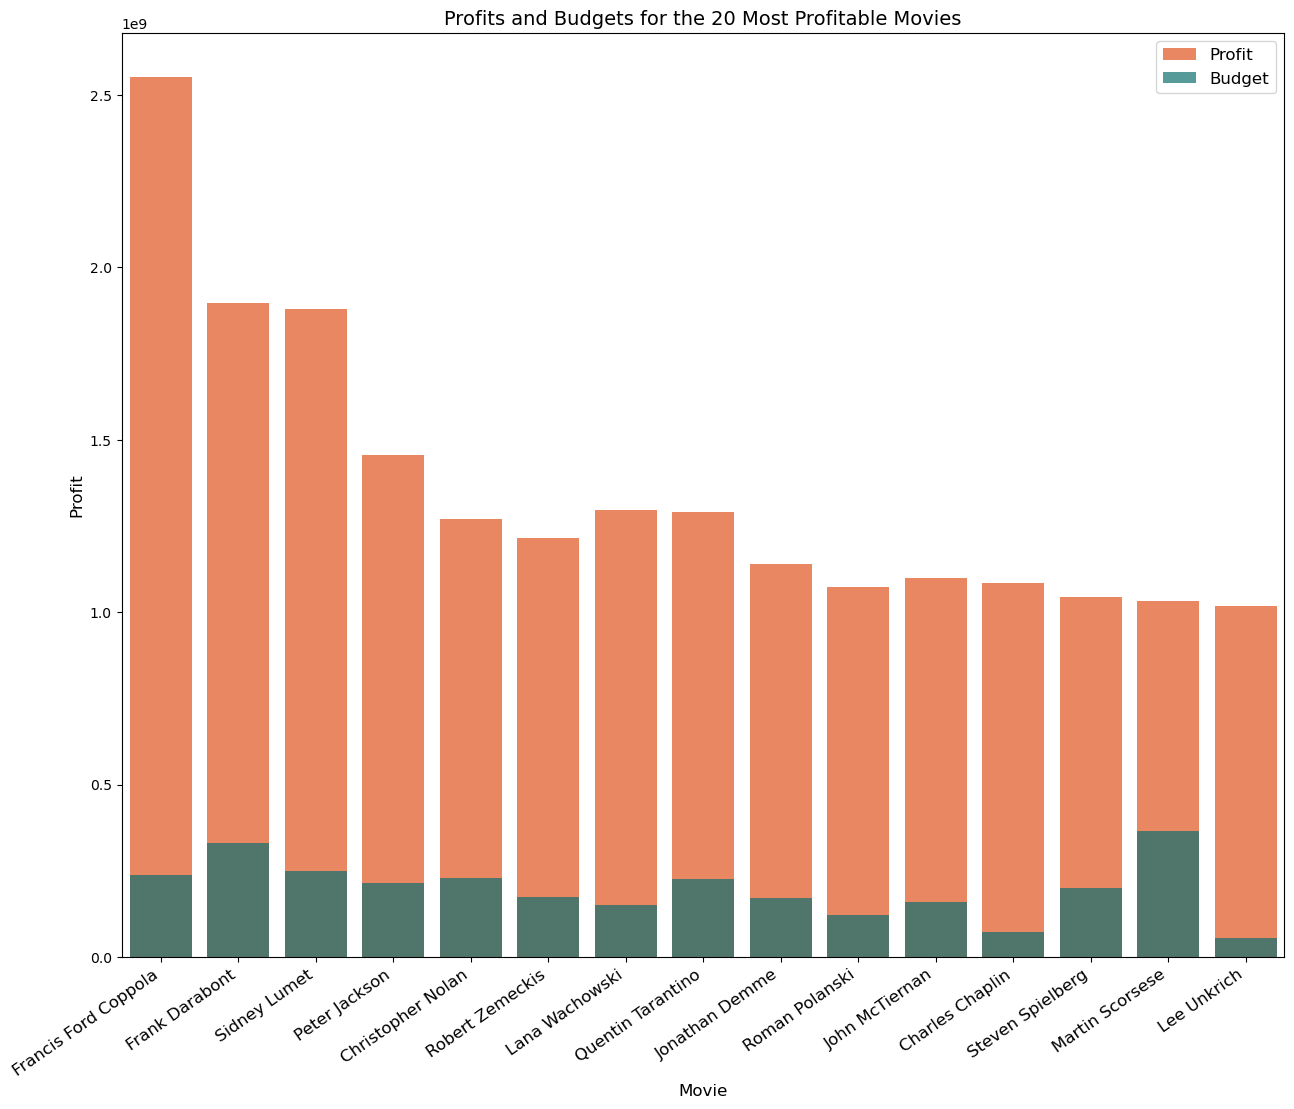

In [659]:
plt.figure(figsize=(15,12))
sns.barplot(x=Top20_ProfitableMovies['Director'],y=Top20_ProfitableMovies['profit'], 
            color='orangered', alpha=0.7, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Director'],y=Top20_ProfitableMovies['Production Budget'], 
            color='teal', alpha=0.7, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Profits and Budgets for the 20 Most Profitable Movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=12)
plt.legend(fontsize=12)

## Impact of actors

HOW TO ACCOUNT FOR DIFFERENT ACTORS ??? only Star1

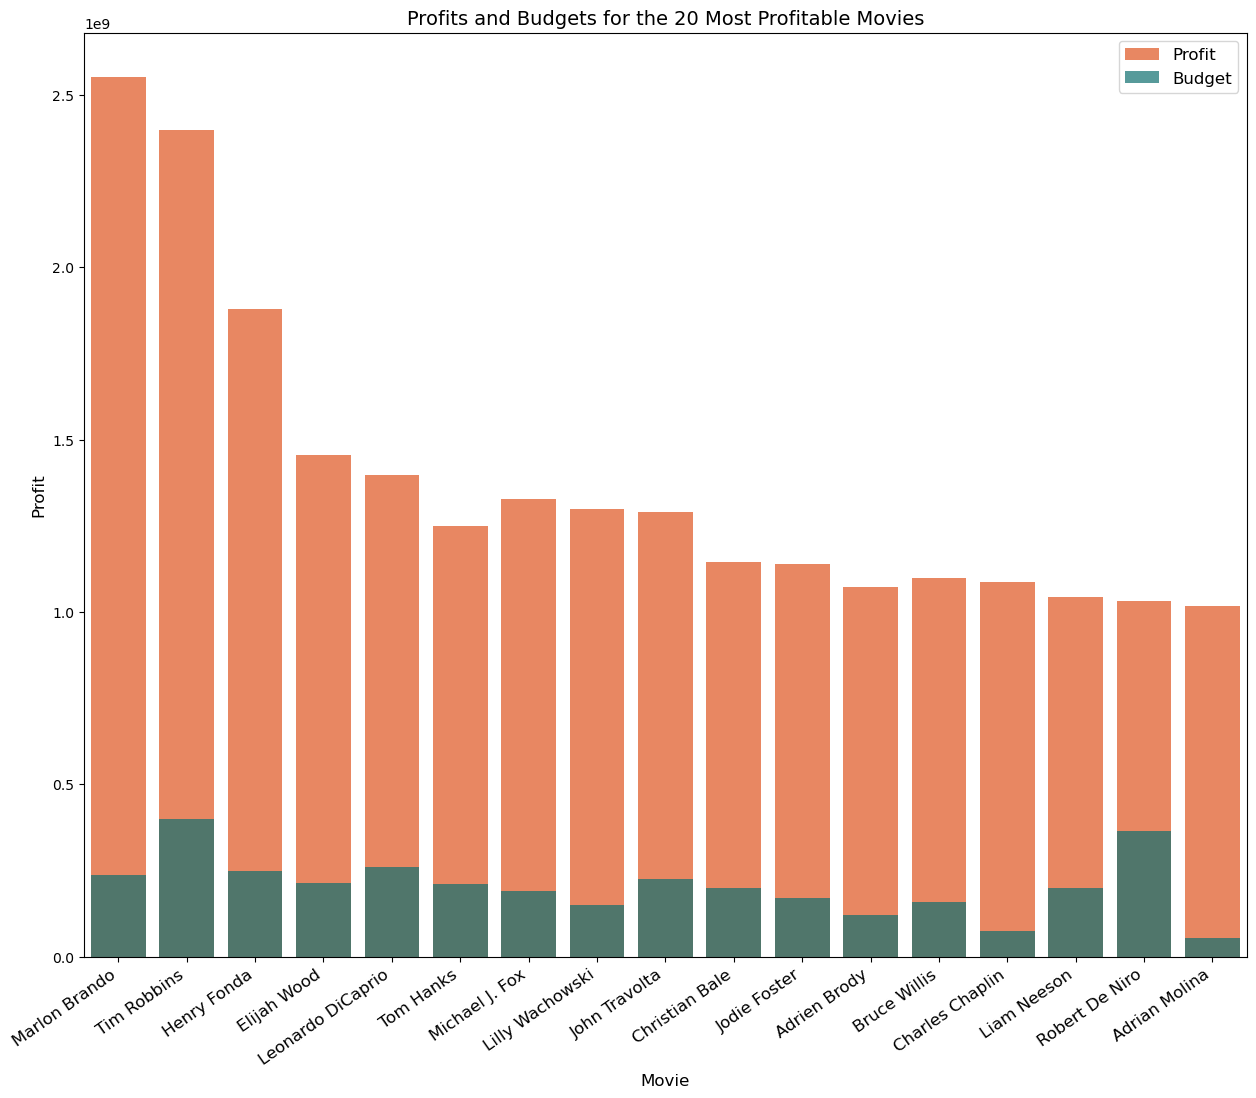

In [660]:
plt.figure(figsize=(15,12))
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['profit'], 
            color='orangered', alpha=0.7, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['Production Budget'], 
            color='teal', alpha=0.7, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Profits and Budgets for the 20 Most Profitable Movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=12)
plt.legend(fontsize=12)

## Popular features in characters

Characters dataset splitted in males and females to easily compare among genders

In [661]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

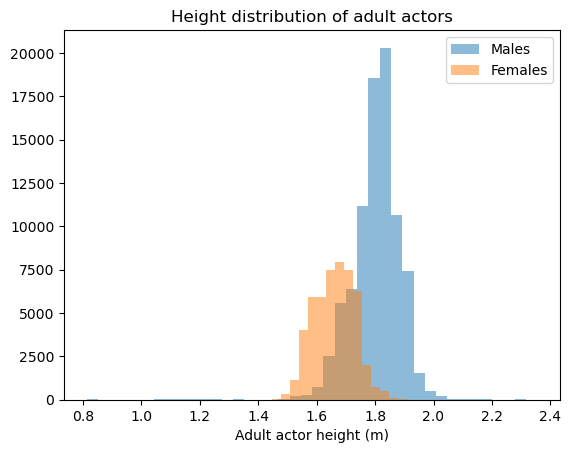

In [662]:
def characters_height_histogram(characters, bins):
    LIMIT_CHILDREN_AGE = 14
    characters_height = characters.dropna(subset=['actor_height_meters'])
    characters_height = characters_height[(characters_height['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]
    plt.hist(characters_height['actor_height_meters'],bins=bins, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Adult actor height (m)')
    plt.title('Height distribution of adult actors')

characters_height_histogram(characters_male, bins=40)
characters_height_histogram(characters_female, bins=25)

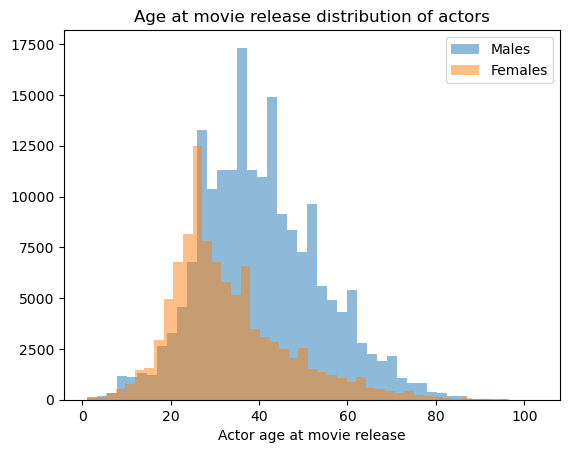

In [663]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')
    plt.title('Age at movie release distribution of actors')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)

## What genres are the most profitable?

In [664]:
movie_feature_with_budget['profit'] = movie_feature_with_budget['Worldwide Gross'] - movie_feature_with_budget['Production Budget']

<AxesSubplot:title={'center':'Movie profit distribution'}, ylabel='Frequency'>

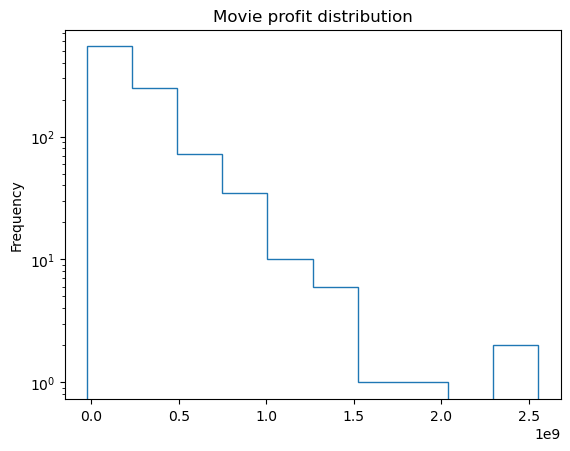

In [665]:
movie_feature_with_budget['profit'].plot(kind='hist', logy=True, histtype='step', title='Movie profit distribution')

In [666]:
movie_feature_with_budget['genre1'] = movie_feature_with_budget['genres'].apply(lambda el: el[0])

<AxesSubplot:title={'center':'Movie genres distribution'}>

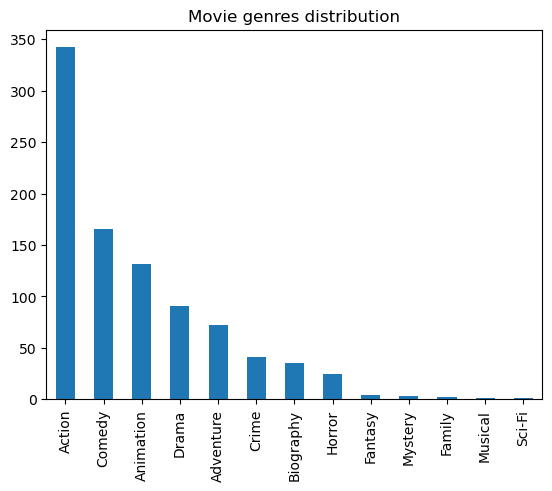

In [667]:
movie_feature_with_budget['genre1'].value_counts().plot(kind='bar', title='Movie genres distribution')

In [668]:
def visualize_genres_profit(genres, means, p025s, p975s, axis, title):
    axis.errorbar(
        np.arange(len(genres)),
        means,
        xerr=0.5,
        yerr=[means - p025s, p975s - means],
        linestyle='', alpha=0.7, color='teal'
    )

    axis.set_title(title)
    print(genres)
    ax.set_xticks(np.arange(len(genres)))
    axis.xaxis.set_major_locator(plt.FixedLocator(np.arange(len(genres))))
    axis.set_xticklabels(genres, rotation=90)


In [669]:
def calculate_average_difference_95_ci(data):
    average_difference = np.mean(data)
    ci_95 = np.percentile(data, [2.5, 97.5])

    return average_difference, ci_95

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Horror', 'Musical', 'Mystery', 'Sci-Fi'],
      dtype='object', name='genre1')


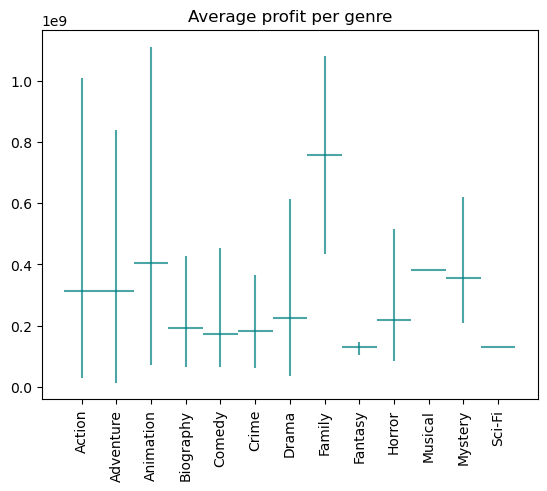

In [670]:
profit = movie_feature_with_budget.groupby('genre1').agg({'profit': calculate_average_difference_95_ci})['profit']

profit_mean = profit.str[0]
profit_p025 = profit.str[1].str[0]
profit_p975 = profit.str[1].str[1]

figure, axis = plt.subplots(1, 1)
visualize_genres_profit(profit_mean.index, profit_mean, profit_p025, profit_p975, axis, 'Average profit per genre')
